## 2.1.8 Challenge: Preparing a Dataset for Modeling

#### Now it's time to play with some data. You're going to work through the stages of model preparation we've covered in this lesson and write up each one. Keep a good record in a Jupyter notebook – we'll come back to your features in a future model-building assignment on Least Squares Regression.

* Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far.
* Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.
* Finally, use filtering methods to select the five best features and justify your choices.

This [dataset](https://www.kaggle.com/xvivancos/barcelona-data-sets) was taken from Kaggle and based on a list of accidents handled by the local police in the city of Barcelona in 2017. Incorporates the number of injuries by severity, the number of vehicles and the point of impact.

I chose this dataset as I have never been to Spain and I am not familiar with their driving habits and therefore would have no bias towards the data.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
%matplotlib inline

import timeit 

In [2]:
# Retrieving dataset
df = pd.read_csv('data/accidents_2017.csv', 
                       sep=',' ,index_col=None, encoding='latin-1')

In [3]:
pd.options.display.max_columns = None
df.head(3)

,Id,District Name,Neighborhood Name,Street,Weekday,Month,Day,Hour,Part of the day,Mild injuries,Serious injuries,Victims,Vehicles involved,Longitude,Latitude
0,2017S008429,Unknown,Unknown,NÃºmero 27 ...,Friday,October,13,8,Morning,2,0,2,2,2.125624,41.340045
1,2017S007316,Unknown,Unknown,NÃºmero 3 Zona Franca / NÃºmero 50 Zona Franca...,Friday,September,1,13,Morning,2,0,2,2,2.120452,41.339426
2,2017S010210,Unknown,Unknown,Litoral (BesÃ²s) ...,Friday,December,8,21,Afternoon,5,0,5,2,2.167356,41.360885


In [4]:
df.shape

(10339, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10339 entries, 0 to 10338
Data columns (total 15 columns):
Id                   10339 non-null object
District Name        10339 non-null object
Neighborhood Name    10339 non-null object
Street               10339 non-null object
Weekday              10339 non-null object
Month                10339 non-null object
Day                  10339 non-null int64
Hour                 10339 non-null int64
Part of the day      10339 non-null object
Mild injuries        10339 non-null int64
Serious injuries     10339 non-null int64
Victims              10339 non-null int64
Vehicles involved    10339 non-null int64
Longitude            10339 non-null float64
Latitude             10339 non-null float64
dtypes: float64(2), int64(6), object(7)
memory usage: 1.2+ MB


In [6]:
pandas_profiling.ProfileReport(df)

Number of variables,15
Number of observations,10339
Total Missing (%),0.0%
Total size in memory,1.2 MiB
Average record size in memory,120.0 B
Numeric,7
Categorical,7
Boolean,0
Date,0
Text (Unique),0
Rejected,1


Thanks to the pandas profiling correlation heatmaps (Pearson & Spearman) we already know there is a high correlation between Mild Injuries and Victims.  I am going to look further into that to see if I can differentiate between the two by groupings.

Interestingly it also discovered 4 duplicated rows with the Id numbers of 2017S003286, 2017S004447, 2017S008856, and 2017S003750.  So I will look into those and see if they are duplicates in all the information or just the id numbers.  We can look into that later.

I need to narrow down the dataset ultimately having an outcome variable and four to five other variables (one to two categorical, three to four continuous) as the base for the features.  


# What is the contributing to accidents in Barcelona?

#### REMOVING
* **Id** - id, has 10,335 distict values(4 duplicates)
* **Day** - Numerical day of the month - This will be helpful for digging deeper such as determining before a big event if the increase in traffic is causing more accidents in a particular intersection.  (ie. holiday events)
* **Neighborhood Name** -  categorical and has 74 unique names.  At the moment, 74 unique names is going to make categorical features a little tricking and consume a lot of power.  This can be used for digging deeper at a later time.
* **Part of the day** - categorical - morning, afternoon, night.  Not as useful at using the hour column, since I can actual find hours when the sunlight might be a factor in an accident.
* **Street** - categorical - 4253 unique fields. Too awkward to work with for creating features, but maybe helpful later if we dig deeper into districts, neighborhood, or decide to map accidents per street.



#### KEEPING

**Categorical Predictor Variables**
* District - 11 unique fields
* Hour - 24 unique fields
* Month - 12 unique fields
* Weekday - 7 unique fields

**Continuous Predictor Variables**
* Mild Injuries - 11 unique values
* Serious Injuries - 4 unique values
* Vehicles involved - 14 unique values, but no limit on vehicles involved
* Victims - Highly correlated with Mild Injuries

* Latitude - 5442 unique values
* Longtitude - 5492 unique values

For easier reading, I will remove the columns that will not be using as explained above and I will simplify the column names.

In [7]:
# Removing columns not being used
df1 = df.drop(columns=['Id','Day','Neighborhood Name','Part of the day','Street'])

In [8]:
# Simplfy column names
df1 = df1.rename({'District Name':'district','Weekday':'weekday','Month':'month', 'Hour':'hour', 
                 'Mild injuries':'mild','Serious injuries':'serious', 'Victims':'victims',
                 'Vehicles involved':'vehicles','Longitude':'longitude','Latitude':'latitude'},
                 axis='columns')

In [9]:
df1.head()

,district,weekday,month,hour,mild,serious,victims,vehicles,longitude,latitude
0,Unknown,Friday,October,8,2,0,2,2,2.125624,41.340045
1,Unknown,Friday,September,13,2,0,2,2,2.120452,41.339426
2,Unknown,Friday,December,21,5,0,5,2,2.167356,41.360885
3,Unknown,Friday,July,2,1,0,1,2,2.124529,41.337668
4,Sant MartÃ­,Thursday,May,14,1,0,1,3,2.185272,41.416365


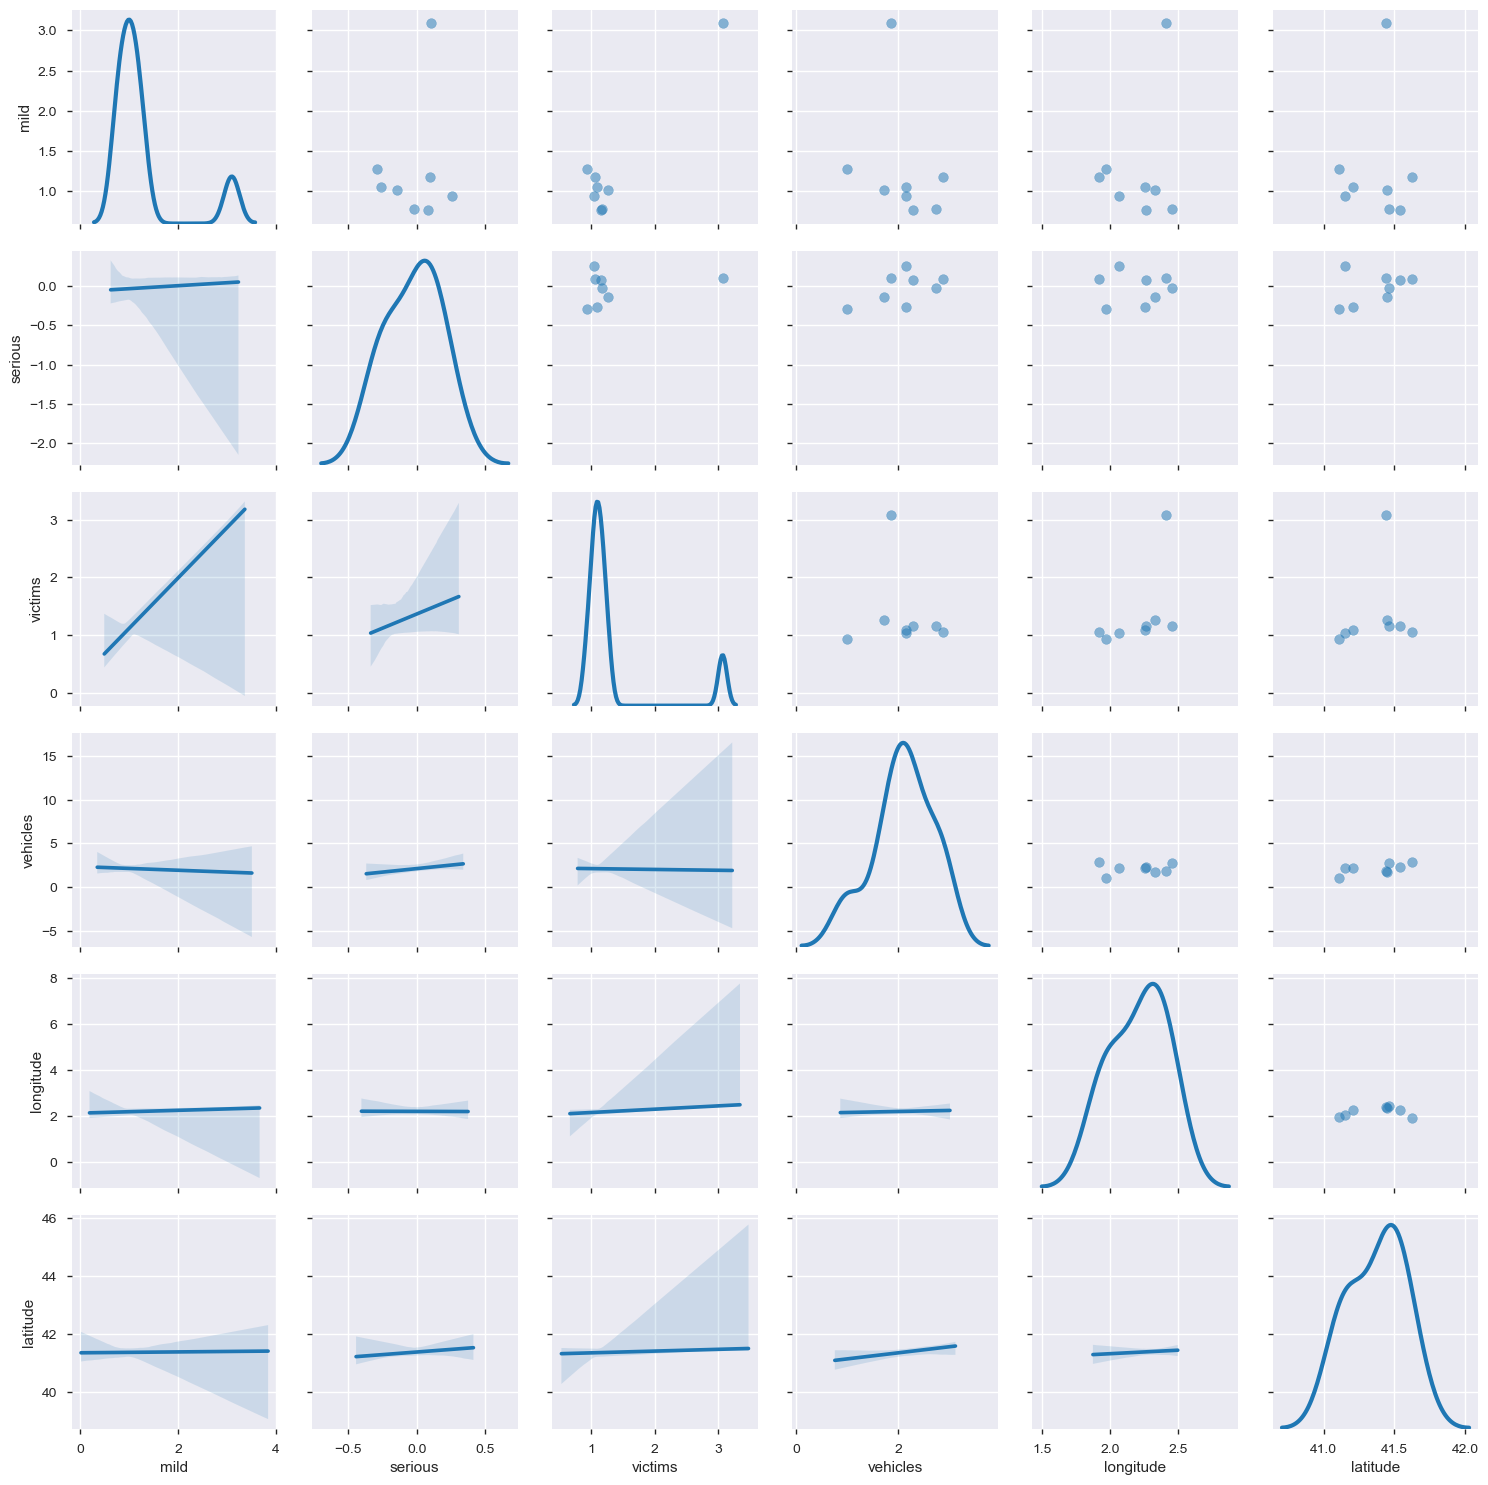

In [10]:
# Take a subset of the data to make plots clearer.
# Selecting two different days of the week
# Selecting May as there are not any major holidays to skew the data in that month
df_busy_days = df1.loc[
    ((df1['weekday'] == 'Tuesday') | (df1['weekday'] == 'Thursday')) & (df1['month'] == 'May'),
    ['weekday','mild', 'serious', 'victims', 'vehicles', 'longitude', 'latitude']
]

# Because the variables can only take integer values between 0 and 10, points
# on the scatterplot will hide one another. To better see all the points, we
# create a dataframe of random noise (or "jitter") and add it only when plotting.

# Make a copy of the data to add jitter to and plot.
df_jittered = df_busy_days.loc[:, 'mild':'latitude'].dropna()
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Other than the high correlation between victims and mild, the plots have no other high correlations.

               mild   serious   victims  vehicles  longitude  latitude
mild       1.000000 -0.117595  0.968085  0.086148   0.007011 -0.039268
serious   -0.117595  1.000000  0.135043  0.021014  -0.035074 -0.013300
victims    0.968085  0.135043  1.000000  0.091259  -0.001857 -0.042536
vehicles   0.086148  0.021014  0.091259  1.000000  -0.011010  0.035417
longitude  0.007011 -0.035074 -0.001857 -0.011010   1.000000  0.391850
latitude  -0.039268 -0.013300 -0.042536  0.035417   0.391850  1.000000


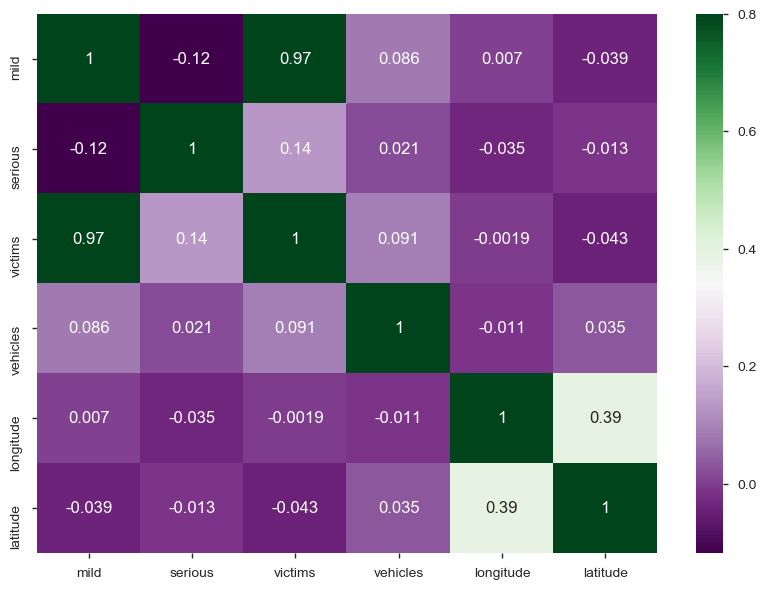

In [11]:
# Make a Correlation Matrix
corrmat = df_busy_days.corr()
print(corrmat)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,7))

# Draw the heatmap seaborn
sns.heatmap(corrmat, vmax=.8, annot=True, annot_kws={'size':12}, cmap='PRGn')
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


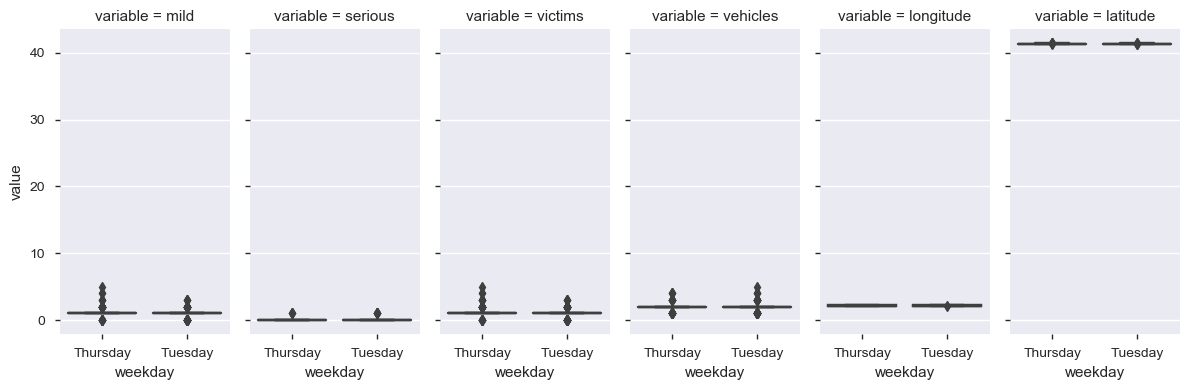

                      mild     serious     victims    vehicles   longitude  \
weekday                                                                      
Thursday count  134.000000  134.000000  134.000000  134.000000  134.000000   
         mean     1.223881    0.022388    1.246269    1.917910    2.164696   
         std      0.732098    0.148497    0.750304    0.575809    0.023561   
         min      0.000000    0.000000    0.000000    1.000000    2.103365   
         25%      1.000000    0.000000    1.000000    2.000000    2.147342   
         50%      1.000000    0.000000    1.000000    2.000000    2.166389   
         75%      1.000000    0.000000    1.000000    2.000000    2.181126   
         max      5.000000    1.000000    5.000000    4.000000    2.214530   
Tuesday  count  179.000000  179.000000  179.000000  179.000000  179.000000   
         mean     1.039106    0.033520    1.072626    1.932961    2.160958   
         std      0.593628    0.180494    0.580855    0.623489  

In [12]:
# Plot all the variables with boxplots for each country.

# Restructure the data so we can use FacetGrid rather than making a boxplot for each
# variable separately
df_long = df_busy_days
df_long = pd.melt(df_long, id_vars=['weekday'])

g = sns.FacetGrid(df_long, col='variable', height=4, aspect=.5)
g = g.map(sns.boxplot, 'weekday', 'value')
plt.show()

# Descriptive statistics by group
print(df_busy_days.groupby('weekday').describe().stack())

# Test whether group differences are significant
for col in df_busy_days.loc[:,'mild':'latitude'].columns:
    print(col)
    print(stats.ttest_ind(
        df_busy_days[df_busy_days['weekday'] == 'Tuesday'][col].dropna(),
        df_busy_days[df_busy_days['weekday'] == 'Thursday'][col].dropna()
    ))

Let's look into another factor that can cause accidents. Sunlight can be blinding when you are driving and that could be a factor contributing to accidents. Let us see how many accidents occur when the sun is out.

In [13]:
# Creating a day and night time column based between hours of the day
# I am selecting the day hours as 6am to 8pm as there is some sunlight during
# those hours for most of the year. 
df1['day'] = np.where((df1['hour'].between(6,20)),1,0) # 6am to 8pm

print(pd.crosstab(df1['day'],df1['hour']))

hour   0    1   2   3   4   5    6    7    8    9    10   11   12   13   14  \
day                                                                           
0     185  134  81  56  82  92    0    0    0    0    0    0    0    0    0   
1       0    0   0   0   0   0  164  308  610  642  495  505  624  719  738   

hour   15   16   17   18   19   20   21   22   23  
day                                                
0       0    0    0    0    0    0  489  353  207  
1     666  645  638  675  648  583    0    0    0  


However we want to know what is contributing to accidents, so let's see if there are more accidents in the day time than the night time.  Sun light would be one of the factors that can contribute to an accident during the day time.

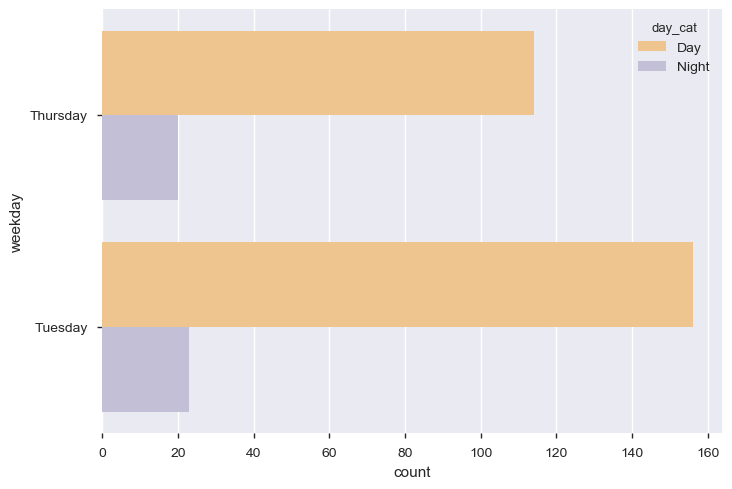

day_cat   Day  Night
weekday             
Thursday  114     20
Tuesday   156     23
Power_divergenceResult(statistic=175.95846645367413, pvalue=6.5795636744768e-38)


In [14]:
# Add a day categorical variable
df_day_cat = df1.loc[
    ((df1['weekday'] == 'Tuesday') | (df1['weekday'] == 'Thursday')) & (df1['month'] == 'May'),
    ['weekday','day']
]

# Create a text variable so that output is easier to interpret
df_day_cat['day_cat']=None
df_day_cat.loc[df_day_cat['day'] == 0, 'day_cat'] = 'Night'
df_day_cat.loc[df_day_cat['day'] == 1, 'day_cat'] = 'Day'

# Plot counts for each combination of levels
sns.countplot(y='weekday', hue='day_cat', data=df_day_cat, palette='PuOr')
plt.show()

# Table of counts
counttable = pd.crosstab(df_day_cat['weekday'], df_day_cat['day_cat'])
print(counttable)

# Test will return a chi-quare test statistic and p-value.  Like the t-test, the chi-square
# is compared against a distribution (the chi-square distribution) to detemine whether
# the group size differences are large enough to reflect differences in the population.
print(stats.chisquare(counttable, axis=None))

#### I think we can safely say more accidents occur during the daylight hours as opposed to night time hours.  So now we just need to figure out what all is contributing to more accidents during the day.

Since our pairplot and heatmap show there is a correlation between mild and victims, we should look into it.

In [15]:
%%timeit
# Creating feature where there are victims and/or mild injuries occurred 
df1['victims1'] = np.where(df1['victims'] == 0,1,0)
df1['mild1'] = np.where((df1['mild'] == 0),1,0)

## .isin is quicker than .between, but have to show all values

742 µs ± 17.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
df1.head(3)

,district,weekday,month,hour,mild,serious,victims,vehicles,longitude,latitude,day,victims1,mild1
0,Unknown,Friday,October,8,2,0,2,2,2.125624,41.340045,1,0,0
1,Unknown,Friday,September,13,2,0,2,2,2.120452,41.339426,1,0,0
2,Unknown,Friday,December,21,5,0,5,2,2.167356,41.360885,0,0,0


In [17]:
print(df1['victims'].groupby(df1['victims1']).describe())

           count    mean       std  min  25%  50%  75%   max
victims1                                                    
0         9437.0  1.2913  0.668289  1.0  1.0  1.0  1.0  10.0
1          902.0  0.0000  0.000000  0.0  0.0  0.0  0.0   0.0


This is interesting as there are 902 (or 8.72%)accidents where there are no victims.  Since there is not a deeper description for this particular item in the dataset, I will interpret it as there was no one hurt in the accident.  This makes the most sense in relation to this dataset.

In [18]:
print(df1['mild'].groupby(df1['mild1']).describe())

        count      mean       std  min  25%  50%  75%   max
mild1                                                      
0      9257.0  1.289079  0.664447  1.0  1.0  1.0  1.0  10.0
1      1082.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0


Again this is interesting as there are 1,082 (or 10.47%) victims with no mild injuries.  However this does not take in account that there may have had victims with serious injuries and no minor injuries.  

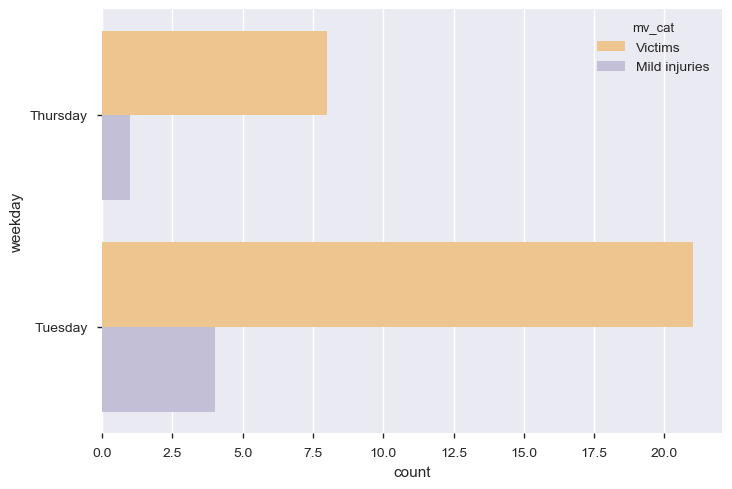

mv_cat    Mild injuries  Victims
weekday                         
Thursday              1        8
Tuesday               4       21
Power_divergenceResult(statistic=27.411764705882355, pvalue=4.825861274437979e-06)


In [19]:
# Adding categorical variables for when there are victims and/or mild injuries at 
# an accident
df_mildvic_cat = df1.loc[
    ((df1['weekday'] == 'Tuesday') | (df1['weekday'] == 'Thursday')) & (df1['month'] == 'May'),
    ['weekday','mild1', 'victims1']
]

# Create a text variable so that output is easier to interpret
df_mildvic_cat['mv_cat']=None
df_mildvic_cat.loc[df_mildvic_cat['mild1'] == 1, 'mv_cat'] = 'Mild injuries'
df_mildvic_cat.loc[df_mildvic_cat['victims1'] == 1, 'mv_cat'] = 'Victims'

# Plot counts for each combination of levels
sns.countplot(y='weekday', hue='mv_cat', data=df_mildvic_cat, palette='PuOr')
plt.show()

# Table of counts
counttable = pd.crosstab(df_mildvic_cat['weekday'], df_mildvic_cat['mv_cat'])
print(counttable)

# Test will return a chi-quare test statistic and p-value.  Like the t-test, the chi-square
# is compared against a distribution (the chi-square distribution) to detemine whether
# the group size differences are large enough to reflect differences in the population.
print(stats.chisquare(counttable, axis=None))

#### It appears there are more victims and more mild injuries on Tuesday compared to Thursday.  Thursday is a better day to avoid being an accident statistic.



I wanted to understand the districts more and thought to group them geographically, such as east and west to see if there is a trend.  So I looked up a [map of Barcelona's districts](https://barcelonamap360.com/barcelona-neighborhood-map#.XVXvjpNKjRY).
 
* **Western districts** - Dist 3: Sants-Monjuic, Dist 4: Les Corts
* **Southern districts** - Dist 1: C.Vella, Dist 2: Eixample
* **Northern districts** - Dist 5: Sarria Sant Gervasi, Dist 6: Gracia
* **Eastern districts** - Dist 7: Horta Guinardo, Dist 8: Nou Barris, Dist 9: Sant Andreu, Dist 10: Sant Marti

In [24]:
df1['district'].unique()

array(['Unknown', 'Sant MartÃ\xad', 'Ciutat Vella', 'Eixample',
       'Sants-MontjuÃ¯c', 'Les Corts', 'SarriÃ\xa0-Sant Gervasi',
       'GrÃ\xa0cia', 'Horta-GuinardÃ³', 'Nou Barris', 'Sant Andreu'],
      dtype=object)

In [21]:
# creating regions of districts

df1['western'] = np.where((df1['district'].isin(['Sants-MontjuÃ¯c','Les Corts'])), 1, 0)

df1['southern'] = np.where((df1['district'].isin(['Ciutat Vella','Eixample'])),1,0)

df1['northern'] = np.where((df1['district'].isin(['SarriÃ\xa0-Sant Gervasi','GrÃ\xa0cia'])),1,0)

df1['eastern'] = np.where((df1['district'].isin(['Horta-GuinardÃ³','Nou Barris',
                                                 'Sant Andreu','Sant MartÃ\xadv'])),1,0)

# From prior project I know that the Unknown districts are not a significant 
# amount and should not affect features
#district_features['unknown'] = np.where((df1['district'].isin(['Unknown'])), 1, 0)

In [31]:
pd.options.display.max_columns = None
df1.tail(3)

,district,weekday,month,hour,mild,serious,victims,vehicles,longitude,latitude,day,victims1,mild1,western,southern,northern,eastern
10336,Sant Andreu,Thursday,December,8,1,0,1,2,2.205607,41.443894,1,0,0,0,0,0,1
10337,Sant Andreu,Friday,July,14,1,0,1,2,2.205118,41.444824,1,0,0,0,0,0,1
10338,Sant Andreu,Sunday,January,20,0,0,0,1,2.200956,41.437125,1,1,1,0,0,0,1


Having the averages of the columns per accident would also be helpful.

In [44]:
total_accidents = 10339

# Average mild injuries per accident
df1['avg_mild'] = (df1['mild'] / total_accidents)*100

# Average serious injuries per accident
df1['avg_serious'] = (df1['serious'] / total_accidents)*100

# Average victims injuries per accident
df1['avg_victim'] = (df1['victims'] / total_accidents)*100

# Average vehicles per accident
df1['avg_veh'] = (df1['vehicles'] / total_accidents)*100

In [45]:
pd.options.display.max_columns = None
df1.head()

,district,weekday,month,hour,mild,serious,victims,vehicles,longitude,latitude,day,victims1,mild1,western,southern,northern,eastern,avg_mild,avg_serious,avg_victim,avg_veh
0,Unknown,Friday,October,8,2,0,2,2,2.125624,41.340045,1,0,0,0,0,0,0,0.019344,0.0,0.019344,0.019344
1,Unknown,Friday,September,13,2,0,2,2,2.120452,41.339426,1,0,0,0,0,0,0,0.019344,0.0,0.019344,0.019344
2,Unknown,Friday,December,21,5,0,5,2,2.167356,41.360885,0,0,0,0,0,0,0,0.048361,0.0,0.048361,0.019344
3,Unknown,Friday,July,2,1,0,1,2,2.124529,41.337668,0,0,0,0,0,0,0,0.009672,0.0,0.009672,0.019344
4,Sant MartÃ­,Thursday,May,14,1,0,1,3,2.185272,41.416365,1,0,0,0,0,0,0,0.009672,0.0,0.009672,0.029016


In [51]:
df2 = df1[['longitude', 'latitude','day', 'victims1','mild1', 'western', 'southern','northern',
 'eastern', 'avg_mild', 'avg_serious', 'avg_victim','avg_veh']].copy()

             longitude  latitude       day  victims1     mild1   western  \
longitude     1.000000  0.396106 -0.024594  0.018190  0.018281 -0.498724   
latitude      0.396106  1.000000  0.009499  0.031905  0.026782 -0.540689   
day          -0.024594  0.009499  1.000000 -0.087841 -0.087634  0.018678   
victims1      0.018190  0.031905 -0.087841  1.000000  0.904290 -0.009567   
mild1         0.018281  0.026782 -0.087634  0.904290  1.000000 -0.003737   
western      -0.498724 -0.540689  0.018678 -0.009567 -0.003737  1.000000   
southern      0.132334 -0.301059 -0.028940 -0.042803 -0.044212 -0.341050   
northern     -0.390964  0.085394  0.008277  0.009731  0.003372 -0.200995   
eastern       0.217397  0.720533  0.001785  0.054015  0.049987 -0.218770   
avg_mild      0.008475  0.014091  0.003836 -0.480731 -0.531612  0.019755   
avg_serious   0.005372  0.000299 -0.026999 -0.043997  0.300510  0.008267   
avg_victim    0.009355  0.013520 -0.002518 -0.495698 -0.466064  0.022781   
avg_veh     

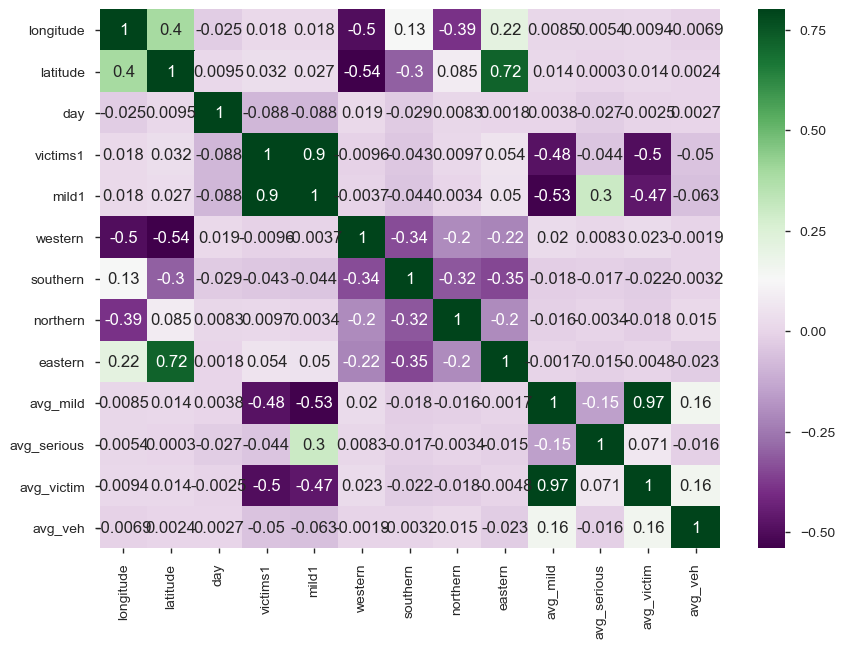

In [52]:
# Make a Correlation Matrix
corrmat = df2.corr()
print(corrmat)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,7))

# Draw the heatmap seaborn
sns.heatmap(corrmat, vmax=.8, annot=True, annot_kws={'size':12}, cmap='PRGn')
plt.show()